### 1. Employee Safety Gear Detection Using MobileNetV2
- In many industrial environments, ensuring that employees adhere to safety protocols by wearing the appropriate safety gear is essential to preventing workplace accidents and maintaining regulatory compliance. Personal protective equipment (PPE), such as helmets and safety vests, is crucial in minimizing risks. However, manual supervision of employee safety compliance can be error-prone and inefficient, especially in large-scale operations.


- This project aims to develop an automated deep learning model that can detect whether employees are wearing appropriate safety gear—specifically, helmets and safety vests—before commencing work. By leveraging image recognition techniques, the model can provide a real-time solution for monitoring workplace safety.

In [18]:
import keras

In [3]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import cv2
from sklearn.model_selection import train_test_split 
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, preprocessing, applications

## 1.1 Dataset:
### The dataset used for this project consists of two sub-folders:

- Wearing Safety Gear Sub-Folder: This contains images of individuals wearing the necessary safety equipment, including helmets and safety vests.
- Not Wearing Safety Gear Sub-Folder:: This sub-folder includes images of people who are not wearing any safety gear.

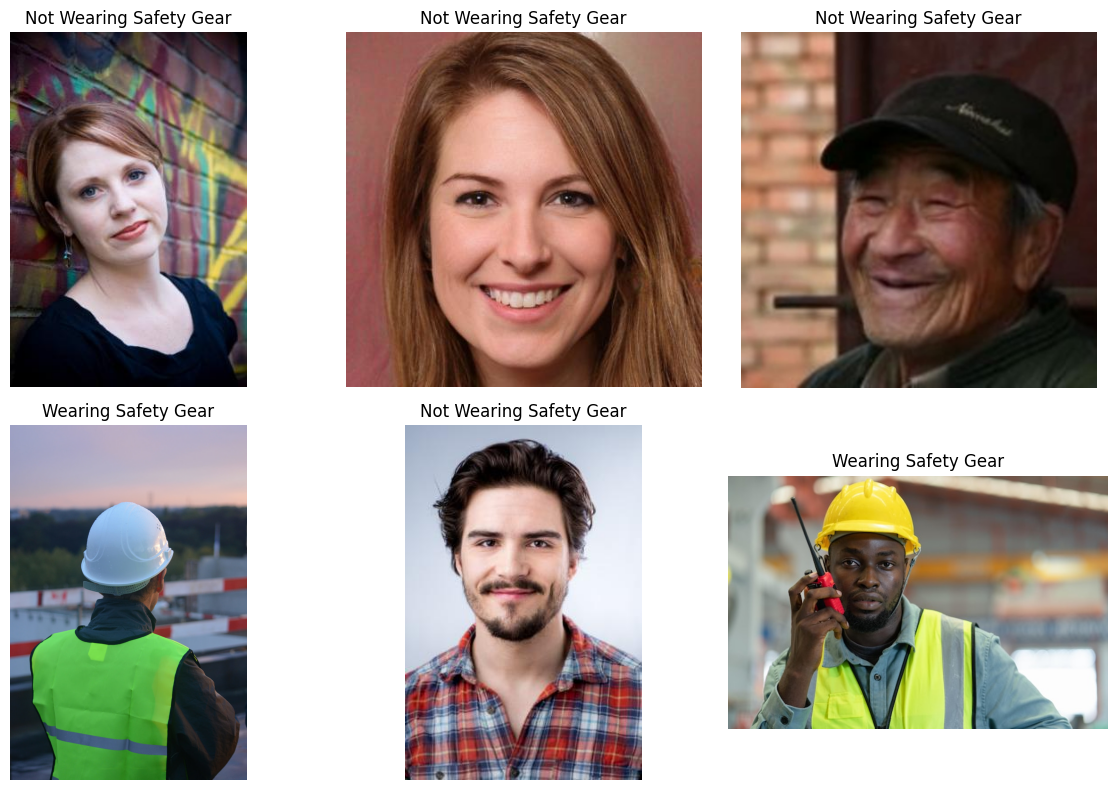

In [2]:
import os
import matplotlib.pyplot as plt
import random

# List of class names
class_names = ['Wearing Safety Gear', 'Not Wearing Safety Gear']
image_paths = []  # Input array
labels = []       # Output array

datadir = r"C:\Users\zahra\Downloads\projectdeep\data\GeardoNot\GearedorNot"

# Path which contains all the categories of images
for class_name in class_names:
    class_dir = os.path.join(datadir, class_name)
    for image_path in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, image_path))
        labels.append(class_name)

# Combine the image paths and labels for shuffling
combined = list(zip(image_paths, labels))

# Shuffle the images randomly
random.shuffle(combined)

# Unzip the shuffled image paths and labels
image_paths, labels = zip(*combined)

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the subplots and display random images
for i in range(2):
    for j in range(3):
        # Select random image path and label
        image_path = image_paths[i * 3 + j]
        label = labels[i * 3 + j]

        # Read the image and display it in the current subplot
        image = plt.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(label)
        axes[i, j].axis('off')  # Hide axes for cleaner presentation

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## 1.2 split data to train , test and validation 

In [4]:
# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% training, 25% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check the sizes of the sets
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Testing set size:", len(x_test))

Training set size: 227
Validation set size: 57
Testing set size: 72


In [5]:
# The shutil module in Python is a standard utility module for performing high-level file and directory operations,
#such as copying, moving, and removing files or directories

import shutil

In [6]:
train_dir= r"C:\Users\zahra\Downloads\projectdeep\data\train"
test_dir= r"C:\Users\zahra\Downloads\projectdeep\data\test"
val_dir= r"C:\Users\zahra\Downloads\projectdeep\data\val"

os.makedirs (train_dir, exist_ok= True)
os.makedirs (test_dir, exist_ok= True)
os.makedirs (val_dir, exist_ok= True)

In [7]:
for image_path, label in zip (x_val, y_val):
    class_dir = os.path.join (val_dir, label)
    os.makedirs (class_dir,exist_ok= True )
    shutil.copy (image_path, class_dir)

In [8]:
for image_path, label in zip (x_train, y_train):
    class_dir = os.path.join (train_dir, label)
    os.makedirs (class_dir,exist_ok= True )
    shutil.copy (image_path, class_dir)

In [9]:
for image_path, label in zip (x_test, y_test):
    class_dir = os.path.join (test_dir, label)
    os.makedirs (class_dir,exist_ok= True )
    shutil.copy (image_path, class_dir)

In [11]:
## Set the image dimensions and batch size
imag_width, image_height=224, 224 # Width and height of the input images (224x224 pixels)
batch_size = 8 # Number of images to process at a time (for training and validation)


train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  


# Create an instance of ImageDataGenerator for validation data without augmentation
val_datagen = ImageDataGenerator(
         rescale=1./255) #This is used for validation data. Unlike training data, 
                         #it doesn’t apply data augmentation but simply normalizes the pixel values to [0, 1] 
                         # for consistent evaluation.

In [12]:
import numpy
numpy.random.seed(42)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(imag_width, image_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(imag_width, image_height),
    batch_size=batch_size,
    class_mode='binary')


Found 226 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


##### MobileNetV2 is a convolutional neural network (CNN) architecture designed for efficient, lightweight deep learning models. It was introduced by Google in 2018 as an improvement over its predecessor, MobileNetV1.  

###### The inverted residual block is a key component of MobileNetV2, designed to improve efficiency and accuracy while maintaining a lightweight architecture. Here's a breakdown of why this structure is used:. It consists of the following layers:

 - 1x1 Convolution (Expand) pointwise : Increases the number of channels of the input feature maps, allows for efficient expansion and projection of feature maps, reducing computational cost (This kernel has a depth of however many channels the input image has ) .
- Depthwise Convolution: Applies a 3x3 kernel to each channel of the expanded feature maps independently.
- 1x1 Convolution (Project): Reduces the number of channels back to the original dimension, enables the network to maintain computational efficiency, combine features, and implement the inverted residual block structure. It plays a significant role in the overall performance and efficiency of the model
- residual connections act as a shortcut that allows information to bypass some layers of the network, ensuring that the gradients can flow smoothly and preventing the network from becoming too difficult to train (loss information(parameter)
- ReLU Activation: ReLU activation functions are applied to introduce non-linearity into the model. 
- Global Average Pooling: This layer reduces the spatial dimensions of the feature maps to a single scalar value for each channel.
- Fully Connected Layer: A fully connected layer is used to combine the extracted features into a fixed-length vector

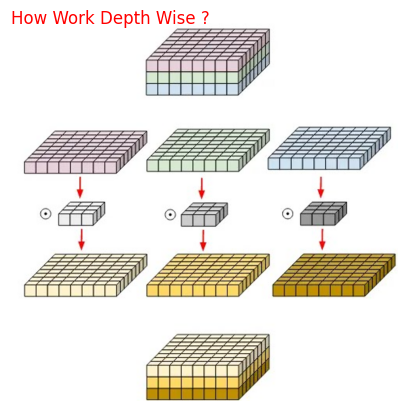

In [13]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(plt.imread(r"C:\Users\zahra\Pictures\Screenshots\Screenshot 2024-08-28 160809.png"))
ax.axis('off')
# Define the text you want to display
text = "How Work Depth Wise ? "

# Define a rectangle as the text box
text_box = Rectangle((0.9, 0.9), 3.8, 3.1, color='white', alpha=0.9)  # Adjust position and size
ax.add_patch(text_box)

# Add the text with appropriate positioning and styling
ax.text(1.15, 1.85, text, ha='left', va='center', fontsize=12, color='red', zorder=3)  # Adjust position and style

# Display the plot
plt.show()

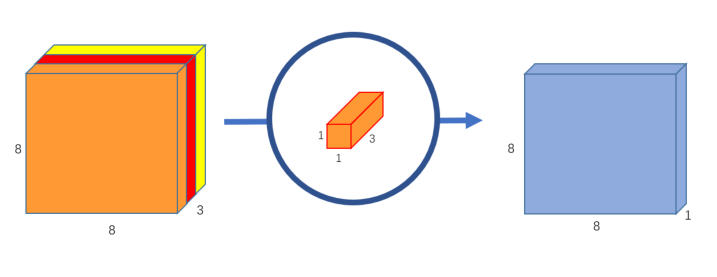

In [14]:

plt.figure(figsize=(9, 9))
plt.imshow(plt.imread(r"C:\Users\zahra\Pictures\Screenshots\point_wise.png"))
plt.axis('off')
plt.show()

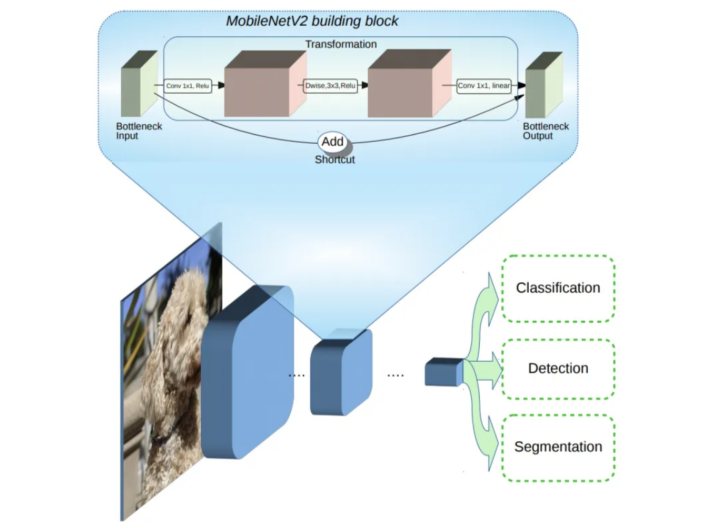

In [15]:
plt.figure(figsize=(9, 9))
plt.imshow(plt.imread(r"C:\Users\zahra\Pictures\Screenshots\Screenshot 2024-08-29 001256.png"))
plt.axis('off')
plt.show()

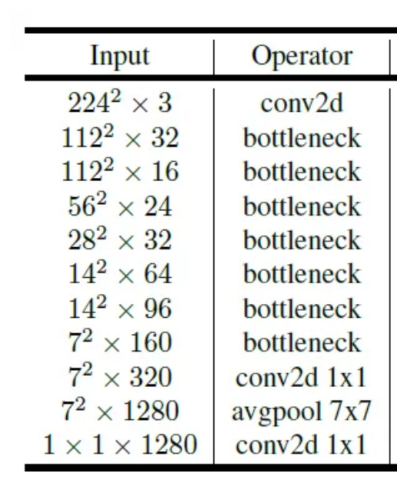

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(plt.imread(r"C:\Users\zahra\Pictures\Screenshots\Screenshot 2024-08-29 003939.png"))
plt.axis('off')
plt.show()

In [19]:
#Loading the Pre-trained MobileNetV2 Model
# `input_shape=(image_width, image_height, 3)` ensures input images are of size 224x224 with 3 channels (RGB)
# `include_top=False` excludes the final classification layer so we can add custom layers
# `weights="imagenet"` Use pre-trained weights from ImageNet
base_model = applications.MobileNetV2(input_shape=(imag_width, image_height, 3),
                                      include_top=False,
                                      weights="imagenet",
                                      )

# Freeze the base model's layers so they won't be updated during training
# This helps retain the learned features from the ImageNet dataset
base_model.trainable = False

# Create a new Sequential model and add custom layers on top of the frozen base model
model = keras.Sequential([
    base_model,  # Use the pre-trained MobileNetV2 as the feature extractor

    # Add a global average pooling layer to reduce each feature map to a single value
    layers.GlobalAveragePooling2D(), # Convert 2D feature maps to 1D by averaging

    # Add a fully connected layer (Dense layer) with 128 units
    # Sigmoid activation is used to introduce non-linearity and capture complex relationships
    layers.Dense(128, activation="sigmoid"),

    # Add the output layer with 1 unit (binary classification) and sigmoid activation
    # The output is a probability value between 0 and 1, suitable for binary classification
    layers.Dense(1, activation="sigmoid")
])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


#### MobileNetV2: A pre-trained convolutional neural network with 1.4 million parameters. It's a lightweight, efficient model that has been trained on the ImageNet dataset.

- 1-GlobalAveragePooling2D: This layer takes the average of the values in each feature map across the spatial dimensions (height and width). This reduces the dimensionality of the output while preserving the most important features.
- 2-Dense(128, activation="sigmoid"): A fully connected layer with 128 neurons and a sigmoid activation function. This layer combines the features extracted by the previous layers into a 128-dimensional vector.
- 3-Dense(1, activation="sigmoid"): The final layer with 1 neuron and a sigmoid activation function. This layer outputs a single value between 0 and 1, which can be interpreted as a probability for a binary classification task.

You must install pydot (`pip install pydot`) for `plot_model` to work.


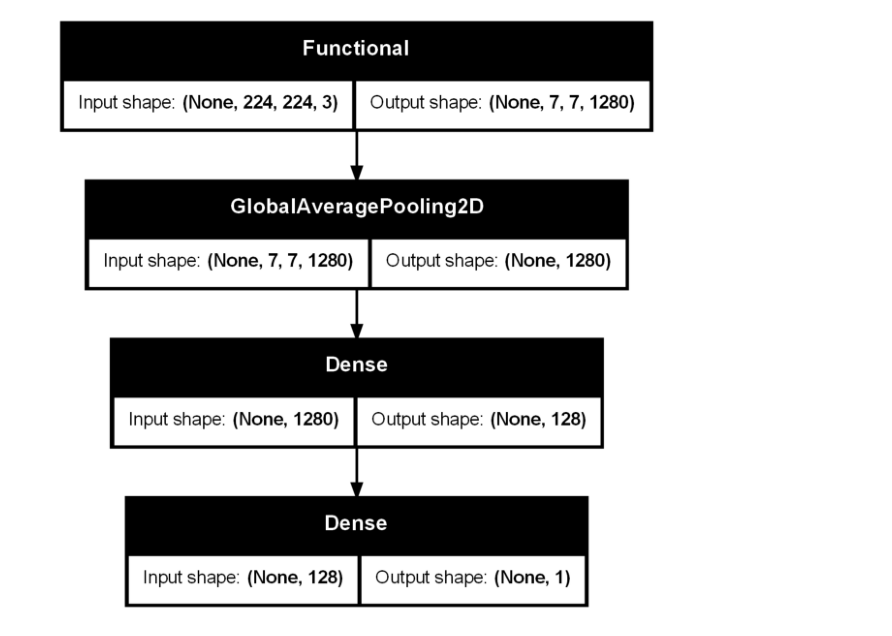

In [20]:
import matplotlib.pyplot as plt
from keras.utils import plot_model

# ... (your existing code)

# Plot the model architecture
plot_model(model, to_file=r'C:\Users\zahra\Downloads\projectdeep\model_architectur.png', show_shapes=True)

# Show the plot
plt.figure(figsize=(12, 8))
plt.imshow(plt.imread(r'C:\Users\zahra\Downloads\projectdeep\model_architectur.png'))
plt.axis('off')
plt.show()

In [22]:

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy","AUC"],
)

In [23]:

history = model.fit(
    train_generator,
    epochs=25,
    batch_size=batch_size,
    validation_data=validation_generator,
)

Epoch 1/25


c:\Users\zahra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - AUC: 0.7112 - accuracy: 0.7049 - loss: 0.6161 - val_AUC: 0.9851 - val_accuracy: 0.9474 - val_loss: 0.3169
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - AUC: 0.9846 - accuracy: 0.9323 - loss: 0.3163 - val_AUC: 0.9905 - val_accuracy: 0.9474 - val_loss: 0.2142
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - AUC: 0.9984 - accuracy: 0.9867 - loss: 0.1854 - val_AUC: 0.9919 - val_accuracy: 0.9298 - val_loss: 0.1843
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - AUC: 0.9942 - accuracy: 0.9510 - loss: 0.1735 - val_AUC: 0.9946 - val_accuracy: 0.9649 - val_loss: 0.1615
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - AUC: 0.9982 - accuracy: 0.9844 - loss: 0.1152 - val_AUC: 0.9946 - val_accuracy: 0.9474 - val_loss: 0.1523
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - AUC: 0.9993 - accuracy: 0.9653 - loss: 0.1131 - val_AUC: 0.9959 - val_accuracy: 0.9649 - val_loss: 0.1416
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step

In [24]:
#save the model 
model.save('employee_safety_model.keras') 

## test model on unseen images and check whether the predictions are correct

Found 72 images belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step


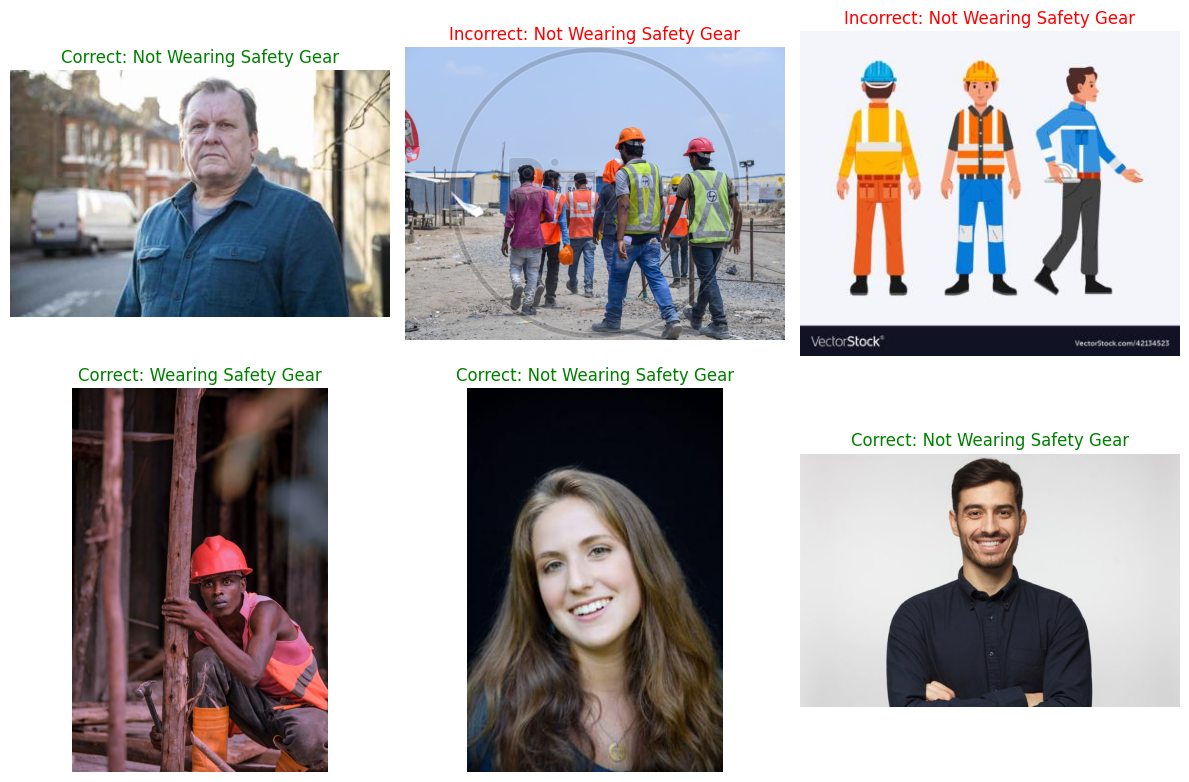

In [33]:
from tensorflow.keras.models import load_model
model = load_model ('employee_safety_model.keras') 
# ImageDataGenerator for test set
test_aug = ImageDataGenerator(rescale=1./255)

# Test directory where images are stored
test_dir = r'C:\Users\zahra\Downloads\projectdeep\data\test' # Replace with your test directory

# Load test images using flow_from_directory
test_generator = test_aug.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False  # Keep the order for proper indexing
)

# Get the true labels and file paths
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
file_paths = test_generator.filepaths

# Shuffle the file paths and true labels together
combined = list(zip(file_paths, true_labels))
random.shuffle(combined)
file_paths, true_labels = zip(*combined)

# Predict on the test images
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions).astype(int)

# Show results for a random selection of images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < len(file_paths):
        # Load and display the image
        image = plt.imread(file_paths[i])
        ax.imshow(image)
        ax.axis('off')

        # Show the true and predicted labels
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_classes[i][0]]
        if true_label == predicted_label:
            ax.set_title(f'Correct: {predicted_label}', color='green')
        else:
            ax.set_title(f'Incorrect: {predicted_label}', color='red')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
